### Adam, Rmsprop, Sgdm with Tree Aggregate Implementation in PySpark
### Author: 
* Yi Rong (yirong@bu.edu)
* Xiaoyang Wang (gnayoaix@bu.edu)

### Date: 05/13/2021

In [1]:
from __future__ import print_function
import sys

from operator import add
# from string import lowercase
from re import sub, search
import numpy as np
from numpy.random.mtrand import dirichlet, multinomial
from string import punctuation
import random
import time
from scipy.stats import norm
import pandas as pd
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame
import matplotlib.cm as cm
from random import sample

from pyspark.sql import functions as f, udf
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.mllib.stat import Statistics
from numpy.linalg import multi_dot
from scipy.stats import multivariate_normal
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

In [2]:
sc = SparkContext(appName="optimizer")

### Generate Data with make_blobs

In [3]:
n_feature = 2 # the number of features
n_components = 2 # the number of clusters

In [4]:
# generate isotropic Gaussian blobs (data from mixture Gaussian distributions)
X, y = make_blobs(n_samples=1000, # the number of total samples
                  centers=n_components, # the number of clusters
                  n_features=n_feature, # the number of features
                  random_state=2) # 2

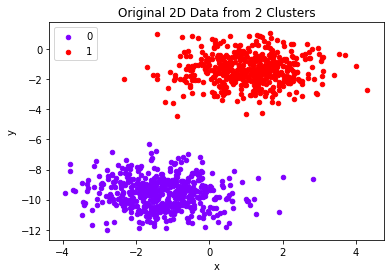

In [5]:
# scatter plot, data points annotated by different colors
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
cluster_name = set(y)
colors = dict(zip(cluster_name, cm.rainbow(np.linspace(0, 1, len(cluster_name)))))
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key].reshape(1,-1))
pyplot.title('Original 2D Data from {} Clusters'.format(n_components))
pyplot.show()

### Train a Logistic Regression Model

In [6]:
# read X, y into rdd
rdd_X = sc.parallelize(X)
rdd_y = sc.parallelize(y)

# split data into train and test
traindata, testdata = rdd_y.zip(rdd_X).randomSplit([0.9, 0.1], seed=12345)
traindata.cache()

PythonRDD[3] at RDD at PythonRDD.scala:53

In [8]:
train_size = traindata.count()

In [9]:
def LogisticRegression(traindata=traindata,
                       max_iteration = 100,
                       learningRate = 0.01,
                       regularization = 0.01,
                       mini_batch_size = 256,
                       tolerance = 0.00001,
                       optimizer = 'None'  #optimizer: 'SGDM' / 'Adam' / 'None'
                      ):

    # initialization
    prev_cost = 0
    L_cost = []
    prev_validation = 0
    train_size = traindata.count()

    parameter_size = len(traindata.take(1)[0][1]) + 1
    np.random.seed(0)
    parameter_vector = np.random.normal(0, 0.1, parameter_size)

    momentum = np.zeros(parameter_size)
    history = np.array(parameter_size)

    for i in range(max_iteration):

        bc_weights = sc.broadcast(parameter_vector[:-1])
        bc1_weights = sc.broadcast(parameter_vector[-1])

        min_batch = traindata.sample(False, mini_batch_size / train_size, 1 + i)

        res = min_batch.treeAggregate((np.zeros(parameter_size), 0, 0),\
              lambda x, y:(x[0]\
                          + (np.append(y[1], 1)) * (-y[0] + (np.exp(np.dot(y[1], bc_weights.value) + bc1_weights.value)\
                          /(1 + np.exp(np.dot(y[1], bc_weights.value) + bc1_weights.value)))),\
                          x[1] \
                          + y[0] * (-(np.dot(y[1], bc_weights.value) + bc1_weights.value)) \
                          + np.log(1 + np.exp(np.dot(y[1],bc_weights.value)+ bc1_weights.value)),\
                          x[2] + 1),
              lambda x, y:(x[0] + y[0], x[1] + y[1], x[2] + y[2]))

        cost =  res[1] + regularization * (np.square(parameter_vector).sum())

        # calculate gradients
        gradient_derivative = (1.0 / res[2]) * res[0] + 2 * regularization * parameter_vector

        if optimizer == 'None':
            parameter_vector = parameter_vector - learningRate * gradient_derivative

        if optimizer =='SGDM':
            beta = 0.9
            momentum = beta * momentum + (1 - beta) * gradient_derivative
            parameter_vector = parameter_vector - learningRate * momentum
            
        if optimizer == 'Adam':
            beta1 = 0.9
            beta2 = 0.999
            epsilon = 10e-8
            momentum = beta1 * momentum + (1 - beta1) * gradient_derivative
            history = beta2 * history + (1-beta2) * (gradient_derivative**2)
            momentum = momentum / (1 - beta1**(i + 1))
            history = history / (1 - beta2**(i + 1))
            parameter_vector = parameter_vector - learningRate * momentum / ((history)**0.5 + epsilon)


        # bold driver
#         if cost > prev_cost:
#             learningRate = learningRate * 0.5

#         if cost < prev_cost:
#             learningRate = learningRate * 1.05
        print("Iteration No.", i, " Cost=", cost)

        # Stop if the cost is not descreasing
        if abs(cost - prev_cost) < tolerance:
            print("cost - prev_cost: " + str(cost - prev_cost))
            break
        prev_cost = cost
        L_cost.append(cost)
        
    return parameter_vector, L_cost

### Model Evaluation

#### None Optimizer

Iteration No. 0  Cost= 255.43562290927585
Iteration No. 1  Cost= 245.64625877851006
Iteration No. 2  Cost= 235.41768156532729
Iteration No. 3  Cost= 229.749901733642
Iteration No. 4  Cost= 221.22630118295004
Iteration No. 5  Cost= 220.0043015289319
Iteration No. 6  Cost= 213.46429090224768
Iteration No. 7  Cost= 236.5340963615425
Iteration No. 8  Cost= 243.58436125708093
Iteration No. 9  Cost= 235.52052317043402
Iteration No. 10  Cost= 229.49292029879658
Iteration No. 11  Cost= 227.68312913047072
Iteration No. 12  Cost= 218.91141811913502
Iteration No. 13  Cost= 216.65745318840504
Iteration No. 14  Cost= 226.8856561123925
Iteration No. 15  Cost= 210.34644751536453
Iteration No. 16  Cost= 207.00308057272198
Iteration No. 17  Cost= 204.32598731615732
Iteration No. 18  Cost= 199.88018137816567
Iteration No. 19  Cost= 206.27346208536605
Iteration No. 20  Cost= 202.37692856393357
Iteration No. 21  Cost= 204.98209482460115
Iteration No. 22  Cost= 207.78719373562856
Iteration No. 23  Cost= 19

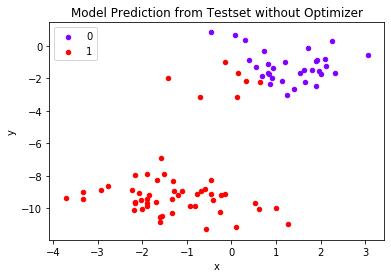

In [11]:
parameter_vector_no, L_cost_no = LogisticRegression(traindata=traindata,
                       max_iteration = 100,
                       learningRate = 0.01,
                       regularization = 0.01,
                       mini_batch_size = 512,
                       tolerance = 10e-8,
                       optimizer = 'None'  #optimizer: 'SGDM' / 'Adam' / 'None'
                      )

confusion matrix: (48, 0, 7, 32)
f1 score: 0.9014084507042254


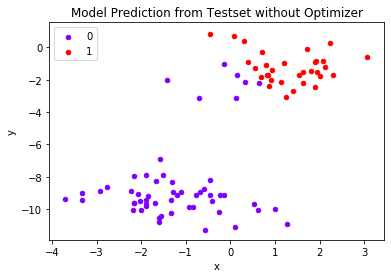

In [15]:
# check parameter_vector * x[1] is positive (label 1) or negative (label 0), x[0] is the actual label
rdd2 = testdata.map(lambda x: (np.dot(np.append(x[1], [1]), parameter_vector_no), x[0])) \
    .map(lambda x: (np.where(x[0] >= 0, 1, 0), x[1])) \

# get confusion matrix result for each row: (TN, FP, FN, TP), 1 for true, 0 for false
rdd3 = rdd2.map(lambda x: (
np.where(x[0] == 0 and x[1] == 0, 1, 0), np.where(x[0] == 1 and x[1] == 0, 1, 0),  # confusion matrix
np.where(x[0] == 0 and x[1] == 1, 1, 0), np.where(x[0] == 1 and x[1] == 1, 1, 0)))

# calculate f1 score
cmat = rdd3.reduce(lambda x, y: (x[0] + y[0], x[1] + y[1], x[2] + y[2], x[3] + y[3]))
print("confusion matrix: " + str(cmat))
TN, FP, FN, TP = cmat[0], cmat[1], cmat[2], cmat[3]

if TP + FP != 0 and TP + FN != 0:
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    f1score = 2 * precision * recall / (precision + recall)
else:
    f1score = 0

print("f1 score: " + str(f1score))

# prediction on test set
y_pred = rdd2.map(lambda x: int(x[0])).collect()
X_test = np.array(testdata.map(lambda x: x[1]).collect())

# scatter plot, data points annotated by different colors
df = DataFrame(dict(x=X_test[:,0], y=X_test[:,1], label=y_pred))
cluster_name = set(y)
colors = dict(zip(cluster_name, cm.rainbow(np.linspace(0,1,len(cluster_name)))))
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key].reshape(1,-1))
pyplot.title('Model Prediction from Testset without Optimizer'.format(n_components))
pyplot.show()

#### Adam

Iteration No. 0  Cost= 255.43562290927585
Iteration No. 1  Cost= 256.17719340201705
Iteration No. 2  Cost= 254.62965275833912
Iteration No. 3  Cost= 255.7158947172702
Iteration No. 4  Cost= 254.3944618940526
Iteration No. 5  Cost= 256.8408512506826
Iteration No. 6  Cost= 255.4675017023254
Iteration No. 7  Cost= 286.45780395694817
Iteration No. 8  Cost= 291.0898791275201
Iteration No. 9  Cost= 288.39529010517924
Iteration No. 10  Cost= 287.6909220166993
Iteration No. 11  Cost= 289.6360023361162
Iteration No. 12  Cost= 285.1240913345115
Iteration No. 13  Cost= 283.5627108434889
Iteration No. 14  Cost= 290.22076865967915
Iteration No. 15  Cost= 269.73497409079846
Iteration No. 16  Cost= 269.98589397871524
Iteration No. 17  Cost= 268.9973673005048
Iteration No. 18  Cost= 268.9358643862886
Iteration No. 19  Cost= 272.7530778447247
Iteration No. 20  Cost= 272.4904907158639
Iteration No. 21  Cost= 270.832294530386
Iteration No. 22  Cost= 274.2038274675369
Iteration No. 23  Cost= 268.891809615

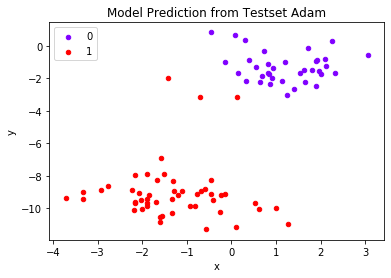

In [12]:
parameter_vector_adam, L_cost_adam = LogisticRegression(traindata=traindata,
                       max_iteration = 100,
                       learningRate = 0.01,
                       regularization = 0.01,
                       mini_batch_size = 512,
                       tolerance = 10e-8,
                       optimizer = 'Adam'  #optimizer: 'SGDM' / 'Adam' / 'None'
                      )



confusion matrix: (48, 0, 3, 36)
f1 score: 0.9600000000000001


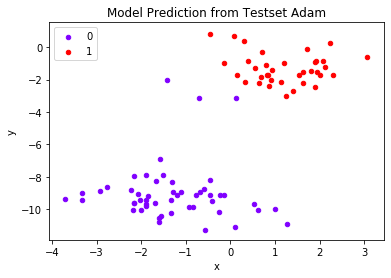

In [16]:
# check parameter_vector * x[1] is positive (label 1) or negative (label 0), x[0] is the actual label
rdd2 = testdata.map(lambda x: (np.dot(np.append(x[1], [1]), parameter_vector_adam), x[0])) \
    .map(lambda x: (np.where(x[0] >= 0, 1, 0), x[1])) \

# get confusion matrix result for each row: (TN, FP, FN, TP), 1 for true, 0 for false
rdd3 = rdd2.map(lambda x: (
np.where(x[0] == 0 and x[1] == 0, 1, 0), np.where(x[0] == 1 and x[1] == 0, 1, 0),  # confusion matrix
np.where(x[0] == 0 and x[1] == 1, 1, 0), np.where(x[0] == 1 and x[1] == 1, 1, 0)))

# calculate f1 score
cmat = rdd3.reduce(lambda x, y: (x[0] + y[0], x[1] + y[1], x[2] + y[2], x[3] + y[3]))
print("confusion matrix: " + str(cmat))
TN, FP, FN, TP = cmat[0], cmat[1], cmat[2], cmat[3]

if TP + FP != 0 and TP + FN != 0:
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    f1score = 2 * precision * recall / (precision + recall)
else:
    f1score = 0

print("f1 score: " + str(f1score))

# prediction on test set
y_pred = rdd2.map(lambda x: int(x[0])).collect()
X_test = np.array(testdata.map(lambda x: x[1]).collect())

# scatter plot, data points annotated by different colors
df = DataFrame(dict(x=X_test[:,0], y=X_test[:,1], label=y_pred))
cluster_name = set(y)
colors = dict(zip(cluster_name, cm.rainbow(np.linspace(0,1,len(cluster_name)))))
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key].reshape(1,-1))
pyplot.title('Model Prediction from Testset Adam'.format(n_components))
pyplot.show()

#### SGDM

Iteration No. 0  Cost= 255.43562290927585
Iteration No. 1  Cost= 255.25590459251006
Iteration No. 2  Cost= 251.63347363900192
Iteration No. 3  Cost= 249.88881191746526
Iteration No. 4  Cost= 244.66438477544855
Iteration No. 5  Cost= 243.51102422770933
Iteration No. 6  Cost= 237.440015014566
Iteration No. 7  Cost= 261.8437516134431
Iteration No. 8  Cost= 264.5843089845882
Iteration No. 9  Cost= 255.93280764886555
Iteration No. 10  Cost= 249.0402004368724
Iteration No. 11  Cost= 245.650915728452
Iteration No. 12  Cost= 235.56412947290838
Iteration No. 13  Cost= 231.40229904068548
Iteration No. 14  Cost= 238.8018755939175
Iteration No. 15  Cost= 220.11920766075494
Iteration No. 16  Cost= 215.83932081202957
Iteration No. 17  Cost= 212.05050705474076
Iteration No. 18  Cost= 206.96492986561174
Iteration No. 19  Cost= 212.51116892010862
Iteration No. 20  Cost= 207.8129597337258
Iteration No. 21  Cost= 210.12489106912727
Iteration No. 22  Cost= 212.38543843877656
Iteration No. 23  Cost= 195.33

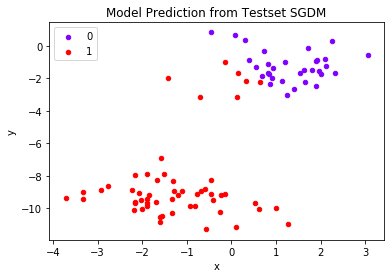

In [13]:
parameter_vector_sgdm, L_cost_sgdm = LogisticRegression(traindata=traindata,
                       max_iteration = 100,
                       learningRate = 0.01,
                       regularization = 0.01,
                       mini_batch_size = 512,
                       tolerance = 10e-8,
                       optimizer = 'SGDM'  #optimizer: 'SGDM' / 'Adam' / 'None'
                      )

confusion matrix: (48, 0, 7, 32)
f1 score: 0.9014084507042254


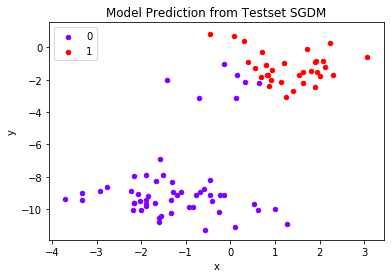

In [17]:
# check parameter_vector * x[1] is positive (label 1) or negative (label 0), x[0] is the actual label
rdd2 = testdata.map(lambda x: (np.dot(np.append(x[1], [1]), parameter_vector_sgdm), x[0])) \
    .map(lambda x: (np.where(x[0] >= 0, 1, 0), x[1])) \

# get confusion matrix result for each row: (TN, FP, FN, TP), 1 for true, 0 for false
rdd3 = rdd2.map(lambda x: (
np.where(x[0] == 0 and x[1] == 0, 1, 0), np.where(x[0] == 1 and x[1] == 0, 1, 0),  # confusion matrix
np.where(x[0] == 0 and x[1] == 1, 1, 0), np.where(x[0] == 1 and x[1] == 1, 1, 0)))

# calculate f1 score
cmat = rdd3.reduce(lambda x, y: (x[0] + y[0], x[1] + y[1], x[2] + y[2], x[3] + y[3]))
print("confusion matrix: " + str(cmat))
TN, FP, FN, TP = cmat[0], cmat[1], cmat[2], cmat[3]

if TP + FP != 0 and TP + FN != 0:
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    f1score = 2 * precision * recall / (precision + recall)
else:
    f1score = 0

print("f1 score: " + str(f1score))

# prediction on test set
y_pred = rdd2.map(lambda x: int(x[0])).collect()
X_test = np.array(testdata.map(lambda x: x[1]).collect())

# scatter plot, data points annotated by different colors
df = DataFrame(dict(x=X_test[:,0], y=X_test[:,1], label=y_pred))
cluster_name = set(y)
colors = dict(zip(cluster_name, cm.rainbow(np.linspace(0,1,len(cluster_name)))))
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key].reshape(1,-1))
pyplot.title('Model Prediction from Testset SGDM'.format(n_components))
pyplot.show()

### Optimizers Comparison

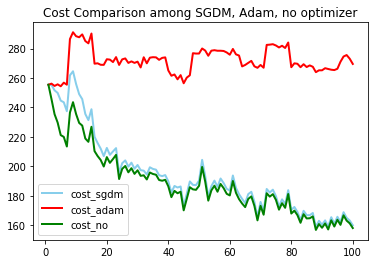

In [20]:
# Data
df = pd.DataFrame({'iteration': range(1, 101), 
                 'cost_sgdm': L_cost_sgdm, 
                 'cost_adam': L_cost_adam, 
                 'cost_no': L_cost_no })
 
# multiple line plots
pyplot.plot( 'iteration', 'cost_sgdm', data=df, marker='', color='skyblue', linewidth=2)
pyplot.plot( 'iteration', 'cost_adam', data=df, marker='', color='red', linewidth=2)
pyplot.plot( 'iteration', 'cost_no', data=df, marker='', color='green', linewidth=2)
# show legend
pyplot.legend()
pyplot.title('Cost Comparison among SGDM, Adam, no optimizer')
# show graph
pyplot.show()

### F1 Score Comparison

* SGDM: 0.901
* Adam: 0.960
* No: 0.901